# **Análise de sentimento dos comentários do Mercado Livre (PT-BR)**
### MVP Hackathon One/Alura

**1.  Contexto**

Esse notebook faz parte do MVP do Hackathon One/Alura e tem como objetivo **treinar um modelo de Data Science capaz de classificar o sentimento de comentários de clientes em três categorias**:


*   positivo
*   neutro
*   negativo

O modelo será posteriormente consumido por uma API REST, permitindo que sistemas de atendimento, marketing
ou operações classifiquem automaticamente novos comentários.

Importante: O modelo usa apenas o texto para prever o sentimento. A nota (rating) **é usada apenas no treinamento**, como proxy para criação dos rótulos.

Este notebook foca exclusivamente na etapa de Data Science
(EDA, criação de rótulos, modelagem e avaliação),
sendo parte de uma solução maior que inclui API e consumo em produção.


2.  **Bibliotecas**


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re




3.   **Carregamento dos Dados**

Os dados foram coletados a partir de avaliações públicas do Mercado Livre.

O dataset foi dividido em dois arquivos JSON apenas por questões
operacionais (volume de dados).
A consolidação não altera a estrutura nem o significado dos registros.




In [2]:
url1 = "https://raw.githubusercontent.com/liinedosanjos/ecommerce-product-dataset/dbb2de8033ab8c091aaa2889c7edc208c18c9612/data/mercadolivre_com_br/reviews_mercadolivre_com_br_2.json"
url2 = "https://raw.githubusercontent.com/liinedosanjos/ecommerce-product-dataset/refs/heads/main/data/mercadolivre_com_br/reviews_mercadolivre_com_br_2.json"

df1 = pd.read_json(url1)
df2 = pd.read_json(url2)


In [3]:
#consolidação dos dados
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,date,rating,content,product_url
0,01 fev. 2025,5,Muito bom gostei.,https://produto.mercadolivre.com.br/MLB-357687...
1,22 jan. 2025,5,"Perfeito. Eu simplesmente amei , ele e maravil...",https://produto.mercadolivre.com.br/MLB-357687...
2,12 jan. 2025,5,Muito cheiroso e a consistência e maravilhosa.,https://produto.mercadolivre.com.br/MLB-357687...
3,29 nov. 2024,4,,https://produto.mercadolivre.com.br/MLB-404730...
4,12 fev. 2025,5,Produto maravilhoso.,https://produto.mercadolivre.com.br/MLB-404730...


3.1   Verificação inicial


In [4]:
df.shape
df.columns


Index(['date', 'rating', 'content', 'product_url'], dtype='object')

4.   **Limpeza inicial dos dados**

Removemos registros sem texto, pois não são úteis para análise de sentimento.

Comentários vazios ou nulos não carregam informação semântica
e poderiam introduzir ruído no treinamento do modelo,
por isso foram removidos.





In [5]:
df = df.dropna(subset=['content'])
df = df[df['content'].str.strip() != ""]


In [6]:
df.shape


(203568, 4)

In [7]:
# Analisamos a distribuição das notas para entender o comportamento do dataset
# e validar o uso do rating como proxy para criação do rótulo de sentimento.

df['rating'].value_counts().sort_index()


,count
rating,
1,8146
2,3268
3,6902
4,12344
5,172908


**5.   Criação do rótulo de sentimento (Trinário)**

Como o dataset não possui sentimento explícito, usamos a nota do cliente como proxy para rotular os comentários.

Para isso, utilizamos a nota (rating) como uma variável proxy. Um proxy é uma informação indireta que representa bem o conceito que queremos modelar — neste caso, o sentimento expresso no texto.

Essa abordagem é amplamente usada em cenários reais de e-commerce e atendimento ao cliente, onde as avaliações numéricas refletem, em média, a satisfação do cliente. A nota, neste caso, é usada apenas na etapa de treinamento para ensinar o modelo associar os padrões linguísticos de sentimentos. Durante a predição, o modelo usa exclusivamente o texto.


Regra adotada (comum em e-commece):

*   Rating 4 ou 5 - positivo
*   Rating 3 - neutro
*   Rating 1 ou 2 - negativo

Apesar de não ser uma representação perfeita do sentimento,
o uso do rating como proxy é suficiente para um MVP
e permite escalar o treinamento sem rotulagem manual,
o que seria inviável neste contexto.


In [8]:
def map_sentiment(r):
  if r >=4:
    return 'Positivo'
  elif r == 3:
    return 'Neutro'
  else:
    return 'Negativo'

df['sentiment'] = df['rating'].apply(map_sentiment)

df['sentiment'].value_counts()



,count
sentiment,
Positivo,185252
Negativo,11414
Neutro,6902




**6.   Análise exploratória (EDA) Essencial**

A análise exploratória foi mantida objetiva, suficiente para entender o comportamento dos dados,
com foco apenas nos aspectos relevantes para a modelagem,
em alinhamento com o escopo de MVP do hackathon.



6.1.   Distribuição dos sentimentos




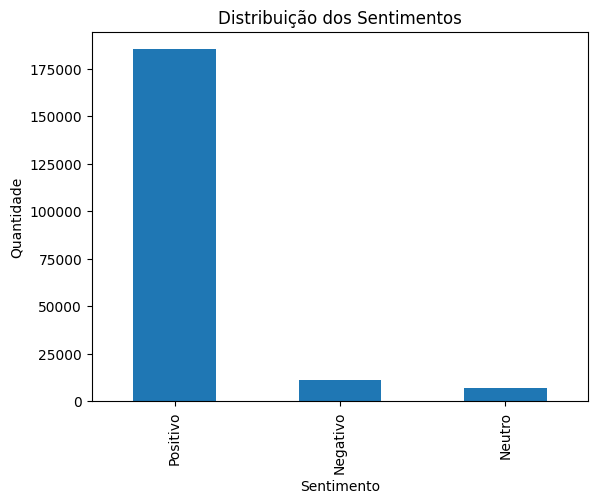

In [9]:
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Distribuição dos Sentimentos')
plt.xlabel('Sentimento')
plt.ylabel('Quantidade')
plt.show()




**6.2.   Tamanho dos Comentários**



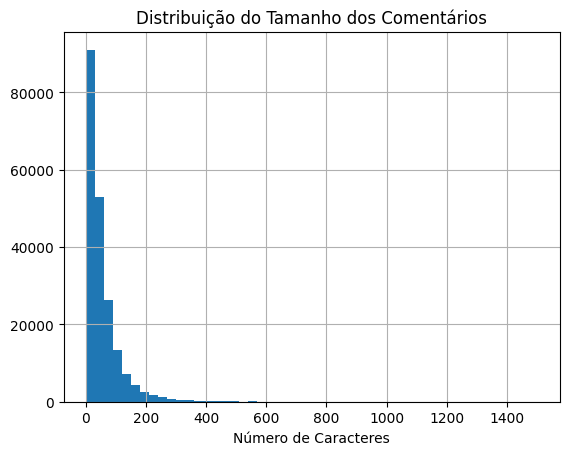

In [10]:
df['content'].str.len().hist(bins=50)
plt.title('Distribuição do Tamanho dos Comentários')
plt.xlabel('Número de Caracteres')
plt.show()



**7.   Limpeza e Normalização de Texto**

Para preparar os textos para o modelo, aplicamos uma limpeza simples:


*   Conversão para minúsculas
*   Remoção de links
*   Remoção de caracteres especiais e pontuação





In [16]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r'http\S+', "", text)
  text = re.sub(r'[^a-záéíóúãõâêôç\s]', '', text)
  text = re.sub(r'[^\w\s]', '', text).strip()
  return text

df['clean_text'] = df['content'].apply(clean_text)

df.head()


,date,rating,content,product_url,sentiment,clean_text,content_clean
0,01 fev. 2025,5,Muito bom gostei.,https://produto.mercadolivre.com.br/MLB-357687...,Positivo,muito bom gostei,muito bom gostei
1,22 jan. 2025,5,"Perfeito. Eu simplesmente amei , ele e maravil...",https://produto.mercadolivre.com.br/MLB-357687...,Positivo,perfeito eu simplesmente amei ele e maravilho...,perfeito eu simplesmente amei ele e maravilho...
2,12 jan. 2025,5,Muito cheiroso e a consistência e maravilhosa.,https://produto.mercadolivre.com.br/MLB-357687...,Positivo,muito cheiroso e a consistência e maravilhosa,muito cheiroso e a consistência e maravilhosa
4,12 fev. 2025,5,Produto maravilhoso.,https://produto.mercadolivre.com.br/MLB-404730...,Positivo,produto maravilhoso,produto maravilhoso
5,20 jan. 2025,5,Muito bom. Veio certinho. Agora é usar pra sab...,https://produto.mercadolivre.com.br/MLB-404730...,Positivo,muito bom veio certinho agora é usar pra saber...,muito bom veio certinho agora é usar pra saber...






**8.   Preparação para Modelagem**





In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**9.Treinamento do Modelo**

Utilizamos um pipeline com:


*   **TF-IDF** para transformar texto em números
*   **Regressão Logística** para classificação multiclasse. Foi escolhida por ser interpretável, rápida, eficiente para textos com TF-IDF e adequada como baseline robusto.

Primeiro usamos o TD-IDF para transfomrar os comentários em vetores numéricos, destacando palavras relevantes para o sentimento. Em seguida, a Regressão logística parende padrões nesses vetores para estimar a probabilidade de cada sentimento.




In [13]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2,),min_df=5,max_df=0.9)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

O desbalanceamento natural entre sentimentos é esperado
em avaliações de e-commerce, com predominância de comentários positivos.
Por isso, utilizamos class_weight='balanced'
para mitigar esse efeito durante o treinamento.


**10. Avaliação do Modelo**

As métricas apresentadas (Precisão, Recall e F-1 Score) permitem avaliar a capacidade do modelo de distinguir os três sentimentos.

In [14]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negativo       0.72      0.88      0.80      2304
      Neutro       0.32      0.83      0.46      1411
    Positivo       1.00      0.92      0.96     36999

    accuracy                           0.92     40714
   macro avg       0.68      0.88      0.74     40714
weighted avg       0.96      0.92      0.93     40714



**11. Serialização do Modelo**

O modelo treinado é salvo em arquivo para ser consumido pela API de back-end.

In [15]:
import joblib
joblib.dump(pipeline, 'sentiment_analysis_model.pkl')

['sentiment_analysis_model.pkl']